# Load Libraries

In [1]:
# Standard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Downsampling
from sklearn.utils import resample

# BoW Method
from sklearn.feature_extraction.text import TfidfVectorizer

# Model
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, precision_score

In [2]:
# Define a dictionary to go between class indices and class names
class_dict = { 'Hate Speech':0, 'Offensive Language':1, 'Neither':2 }
class_dict_inv = {value: key for key, value in class_dict.items()}

# Load Preprocessed Data with Features

In [3]:
df = pd.read_csv('parsed_data_with_features.csv')

There are two FRE scores that are NaNs, we should explore why, but for now we simply remove them.

In [4]:
df.dropna(axis='index', how='any', inplace=True)
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,clean tweet,stemmed tweet,sentiment score,FRE score
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,exclamationmark mentionhere woman complain cle...,exclamationmark mentionhere woman complain cle...,-0.3612,71.815000
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,exclamationmark mentionhere boy dats cold tyga...,exclamationmark mentionhere boy dat cold tyga ...,-0.5423,126.451818
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,exclamationmark mentionhere dawg exclamationma...,exclamationmark mentionhere dawg exclamationma...,-0.9423,103.540000
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,exclamationmark mentionhere mentionhere look l...,exclamationmark mentionhere mentionhere look l...,0.3612,119.190000
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,exclamationmark mentionhere shit hear might tr...,exclamationmark mentionhere shit hear might tr...,-0.6808,113.100000
...,...,...,...,...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,yous muthaf lie emoticonhere mentionhere menti...,yous muthaf lie emoticonhere mentionhere menti...,0.0000,129.005000
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an...",gone broke wrong heart baby drove redneck crazy,go broke wrong heart baby drove redneck crazy,-0.8074,103.540000
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...,young buck wanna eat exclamationmark dat niggu...,young buck wanna eat exclamationmark dat niggu...,0.3612,86.705000
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies,youu got wild bitches tellin lies,youu get wild bitch tellin lie,-0.5859,116.145000


# Downsampling
Right now the classes are not balanced, which could lead to problems for the classifier, weighting something more than other. For example classifying everything as offensive seems to be a good strategy for obtaining a high precision immediately. To avoid this we want to downsample, since we are not able to upsample, wihtout scraping new twitter data and crowdsourcing the classification resulting in the true samples. The downsampling means we will reduce the data we use, so we have equal number of tweets in each class.

In [5]:
# Get the number of tweets for the class with fewest tweets
N_hate = np.sum(df['class']==0)
N_offensive = np.sum(df['class']==1)
N_neither = np.sum(df['class']==2)

class_names = ['Hate Speech', 'Offensive', 'Neither']
smallest_class_idx = np.argmin([N_hate,N_offensive,N_neither])
N_tweets_pr_class = np.array([N_hate,N_offensive,N_neither])[smallest_class_idx]

print(f'The class with fewest tweets is: {smallest_class_idx}={class_names[smallest_class_idx]}')
print(f'This class contains: {N_tweets_pr_class} tweets')

The class with fewest tweets is: 0=Hate Speech
This class contains: 1430 tweets


In [6]:
# Dataframe for Hate
hate_mask = (df['class'] == 0)
df_hate = df[hate_mask]

# Random Sampling of the larger classes
off_mask = (df['class'] == 1)
df_off = df[off_mask].sample(n=N_tweets_pr_class, replace=False, random_state=1, axis=0)

neither_mask = (df['class'] == 2)
df_neither = df[neither_mask].sample(n=N_tweets_pr_class, replace=False, random_state=1, axis=0)

# Put them together into a new dataframe
df_downsampled = pd.concat([df_hate, df_off, df_neither], axis=0)
df_downsampled.sort_values('Unnamed: 0', axis=0, ascending=True, inplace=True)

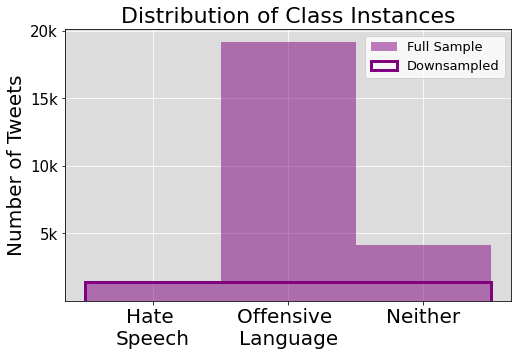

In [7]:
# Plot how many of each class we have
fig, ax = plt.subplots(figsize=(8,5))

ax.set_facecolor('gainsboro')
ax.grid(color='white')

# Current sample
ax.hist(df['class'], bins=np.arange(-0.5,2.5+1, 1), color='purple', alpha=0.5, zorder=2, label='Full Sample')

# Downsampled sample
ax.hist(df_downsampled['class'], bins=np.arange(-0.5,2.5+1, 1), color='purple', zorder=3, 
        histtype='step', linewidth=3, label='Downsampled')

ax.legend(prop={'size':13})
plt.xticks([0,1,2], labels=['Hate \nSpeech', 'Offensive \nLanguage', 'Neither'], fontsize=20)
plt.yticks([5000, 10000, 15000, 20000],['5k','10k','15k','20k'], fontsize=15)
ax.set_ylabel('Number of Tweets', fontsize=20)
ax.set_title('Distribution of Class Instances', fontsize=22)
plt.show()

# Split into Train and Test Data
X should be shape (n_samples, n_features) and contains all the parameters:
- the parsed tweet
- the sentiment score
- the FRE score
Y should be shape (n_samples,) and containes the labels, in this case the 'class' column

These will be split in the same way into a train and a test sample with the same shapes but fewer samples in each.

In [8]:
# Extract X and Y
X = df_downsampled[['stemmed tweet', 'sentiment score', 'FRE score']]
Y = df_downsampled['class']

# Define test size
test_sz = 0.2

# Split up the sample
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_sz, random_state=1)

# Get stats from each sample
print('------------------TRAIN------------------')
print(f'Total tweets: {len(Y_train)}')
print(f'Hate speech tweets: { np.sum(Y_train==0) } \t {np.sum(Y_train==0)/len(Y_train)*100:.2f} %')
print(f'Offensive tweets: { np.sum(Y_train==1) } \t {np.sum(Y_train==1)/len(Y_train)*100:.2f} %')
print(f'Neither tweets: { np.sum(Y_train==2) } \t\t {np.sum(Y_train==2)/len(Y_train)*100:.2f} %')
print('\n')
print('------------------TEST-------------------')
print(f'Total tweets: {len(Y_test)}')
print(f'Hate speech tweets: { np.sum(Y_test==0) } \t {np.sum(Y_test==0)/len(Y_test)*100:.2f} %')
print(f'Offensive tweets: { np.sum(Y_test==1) } \t\t {np.sum(Y_test==1)/len(Y_test)*100:.2f} %')
print(f'Neither tweets: { np.sum(Y_test==2) } \t\t {np.sum(Y_test==2)/len(Y_test)*100:.2f} %')


------------------TRAIN------------------
Total tweets: 3432
Hate speech tweets: 1144 	 33.33 %
Offensive tweets: 1142 	 33.28 %
Neither tweets: 1146 		 33.39 %


------------------TEST-------------------
Total tweets: 858
Hate speech tweets: 286 	 33.33 %
Offensive tweets: 288 		 33.57 %
Neither tweets: 284 		 33.10 %


# TF-IDF on Train (.fit_transform) and Test (.transform)

In [9]:
# Initialise vectorizor
vectorizer = TfidfVectorizer(analyzer='word')

# Fit the vectorizor to the train data and transform the data accordingly
# NOTICE we use only the stemmed tweets for this part (since this is what we count words in)
Xt_train_tweets = vectorizer.fit_transform(X_train['stemmed tweet']).toarray()

# Get a dictionary mapping terms to indices
word_to_index = vectorizer.vocabulary_
# Invert it
index_to_word = {value: key for key, value in word_to_index.items()}
# Make column names into words
word_col_names = [ index_to_word[i] for i in np.arange(len(index_to_word)) ]
# Create data frame with the right col names
Xt_train_tweets = pd.DataFrame(Xt_train_tweets, columns=word_col_names, index=X_train['stemmed tweet'].index)

# Concatenate with the other features
other_features=['sentiment score', 'FRE score']
Xt_train = pd.concat([ Xt_train_tweets, X_train[[*other_features]] ], axis=1)

In [10]:
# Do the same on the test, but without the fitting part
Xt_test_tweets = vectorizer.transform(X_test['stemmed tweet']).toarray()
Xt_test_tweets = pd.DataFrame(Xt_test_tweets, columns=word_col_names, index=X_test['stemmed tweet'].index)
Xt_test = pd.concat([ Xt_test_tweets, X_test[[*other_features]] ], axis=1)

# Select Best Features

Optional: explore whether we can set the class weights to have something to do with how many people was involved in the classification or how much they agreed somehow telling us how reliable the true label actually is.

In [45]:
# Initialise model
model_test = LinearSVC(class_weight='balanced',C=0.1, penalty='l2', loss='squared_hinge',
                  multi_class='ovr', max_iter=1e6).fit(Xt_train, Y_train)

In [46]:
# SelectFromModel finds best features
selector = SelectFromModel(model_test, prefit = True, threshold=0.05)

# Get a mask for extracting the chosen feature names
mask = selector.get_support()
best_feature_names = Xt_train.columns.values[mask]

# Transform tweets by removing unwanted features
Xt_train_best = selector.transform(Xt_train)
Xt_test_best = selector.transform(Xt_test)

# Make pandas with column names
Xt_train_best = pd.DataFrame(Xt_train_best, columns=best_feature_names, index=X_train['stemmed tweet'].index)
Xt_test_best = pd.DataFrame(Xt_test_best, columns=best_feature_names, index=X_test['stemmed tweet'].index)

# Print how many is removed
print(f'We have removed {len(Xt_train.columns)-len(Xt_train_best.columns)} features.')
print(f'The total number of parameters is now {len(Xt_train_best.columns)}')

We have removed 279 features.
The total number of parameters is now 5817


In [47]:
# Initialise model
model = LinearSVC(class_weight='balanced',C=0.1, penalty='l2', loss='squared_hinge', multi_class='ovr', max_iter=1e5).fit(Xt_train_best, Y_train)

# Make predictions on the train data
Y_train_preds = model.predict(Xt_train_best)

In [141]:
def plot_conf_mat(y_true, y_pred, plot_threshold, normalize=False, save=False, fname='test'):
    
    # Make figure
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Compute confusion matrix
    conf_mat = confusion_matrix(y_true, y_pred)
        
    # Normalise if states and plot conf_mat with percentages
    if normalize:
        conf_mat = conf_mat / conf_mat.astype(np.float).sum(axis=0)
        
        #ax.set_title('Normalised Confusion Matrix', fontsize=16)
        ax.imshow(conf_mat, cmap='Purples')
        for i in range(3):
            for j in range(3):
                if conf_mat[i,j] < plot_threshold:
                    ax.text(i,j, f'{conf_mat[i,j]*100:.2f}%', horizontalalignment='center', color='k', fontsize=15)
                else:
                    ax.text(i,j,f'{conf_mat[i,j]*100:.2f}%', horizontalalignment='center', color='w', fontsize=15)

    # Plot conf mat with integers
    else:
        ax.set_title('Unnormalised Confusion Matrix', fontsize=16)
        ax.imshow(conf_mat, cmap='Purples')
        for i in range(3):
            for j in range(3):
                if conf_mat[i,j] < plot_threshold:
                    ax.text(i,j, f'{conf_mat[i,j]}', horizontalalignment='center', color='k', fontsize=15)
                else:
                    ax.text(i,j,f'{conf_mat[i,j]}', horizontalalignment='center', color='w', fontsize=15)
                    
    # Plot true and predictive suptitles
    ax.text(x=-1.2,y=1.5,s='True Class',rotation='vertical',fontsize=18, fontweight=580)
    ax.text(x=0.2,y=3.2,s='Predicted Class',fontsize=18, fontweight=580)

    # Make it prettay
    plt.xticks([0,1,2], labels=['Hate \nSpeech', 'Offensive \nLanguage', 'Neither'], fontsize=14)
    plt.yticks([0,1,2], labels=['Hate \nSpeech', 'Offensive \nLanguage', 'Neither'], rotation=90,fontsize=14)
    plt.tight_layout()
    
    if save:
        plt.savefig('Plots/'+fname+'.pdf')
    plt.show()

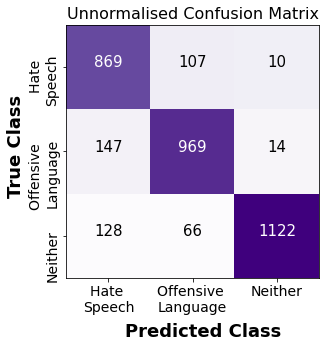

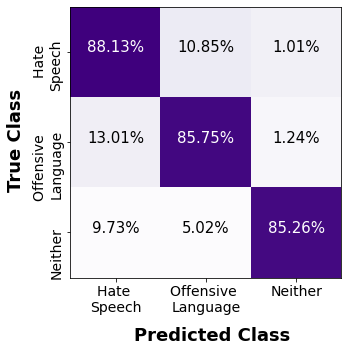

In [142]:
plot_conf_mat(Y_train, Y_train_preds, plot_threshold=150, normalize=False)
plot_conf_mat(Y_train, Y_train_preds, plot_threshold=0.5, normalize=True, save=True, fname='conf_train_TDIDF' )

In [143]:
precision_score(Y_train, Y_train_preds, average=None)

array([0.88133874, 0.85752212, 0.85258359])

# Test Model

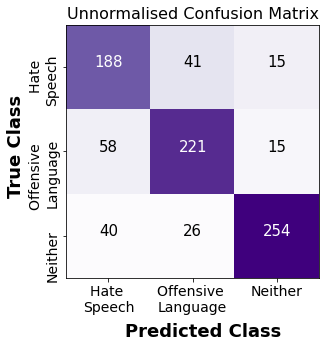

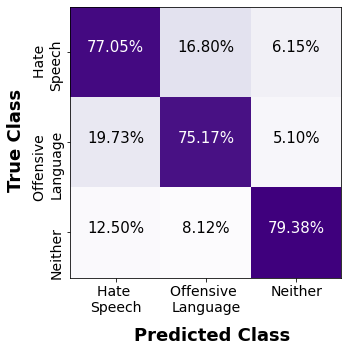

In [144]:
# Make predictions on the test data
Y_test_preds = model.predict(Xt_test_best)

# Plot confusion matrix
plot_conf_mat(Y_test, Y_test_preds, plot_threshold=150, normalize = False)
plot_conf_mat(Y_test, Y_test_preds, plot_threshold=0.5, normalize = True, save=True, fname='conf_test_TDIDF')

In [145]:
precision_score(Y_test, Y_test_preds, average=None)

array([0.7704918 , 0.75170068, 0.79375   ])

# Feature Importance
https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn

In [146]:
# Define a function that can produce a feature importance plot
def plot_feature_importance(model, feature_names=best_feature_names, n_features=10, save=False, fname='test'):
    """
    model = the model that was trained
    n_features = number of features to display, will display the best ones
    """
    
    # Create figure with an ax for each class
    fig, ax = plt.subplots(ncols=3, figsize=(18,10), gridspec_kw={'wspace':0.4})
    
    # Loop over classes
    for i in range(3):
        
        # Extract feature importance from coef in the shape (n_classes, n_features)
        imp = model.coef_[i]

        # Get the position of the highest n_features (absolute) importance
        sort_idx = np.argsort( abs(imp) )[::-1]
        sort_imp = imp[sort_idx]
        sort_names = feature_names[sort_idx]
        
        ax[i].barh(y=np.arange(n_features), width=sort_imp[:n_features], height=0.8, align='center', 
                   color='purple', zorder=2)
        
        ax[i].set_yticks(np.arange(n_features))
        ax[i].set_yticklabels(sort_names[:n_features], fontsize=15)
        ax[i].set_ylim(n_features-0.5, 0.5)
        ax[i].tick_params(axis='x', labelsize=15)
    
        ax[i].set_title(f'Top {n_features} Important Features \nfor Classifying {class_dict_inv[i]}', 
                        fontsize=20)
    
        ax[i].set_facecolor('gainsboro')
        ax[i].grid(color='white')
        ax[i].set_xlabel('Feature Importance (.coef_)', fontsize=15)
    
    plt.tight_layout()
    
    if save:
        plt.savefig('Plots/'+fname+'.pdf')
        
    plt.show()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


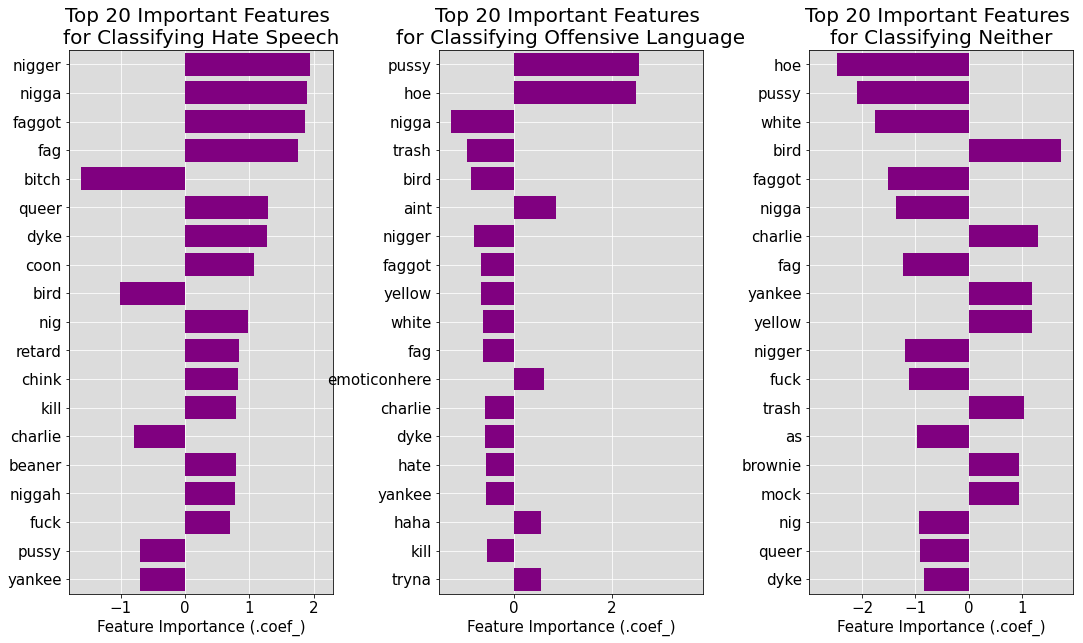

In [147]:
plot_feature_importance(model, n_features=20, save=True)

In [53]:
# Get feature importance for sentiment and readability, did we do it for no reason?

# Get idx for each
sent_idx = (best_feature_names=='sentiment score')
FRE_idx = (best_feature_names=='FRE score')

# Get the feature importance
for i in range(3):
    print(f'------For classiying {class_dict_inv[i]}-------')
    importance = model.coef_[i]
    print(f'Sentiment Score: importance={importance[sent_idx][0]}')
    print(f'FRE Score: importance={importance[FRE_idx]}')

------For classiying Hate Speech-------
Sentiment Score: importance=-0.33829111251653454
FRE Score: importance=[]
------For classiying Offensive Language-------
Sentiment Score: importance=-0.20082095475046094
FRE Score: importance=[]
------For classiying Neither-------
Sentiment Score: importance=0.5673996539550111
FRE Score: importance=[]


So FRE score is not even used in the model...

In [164]:
# Define a function that can produce a feature importance plot
def plot_feature_importance_HATE(model, feature_names=best_feature_names, n_features=10, save=False, fname='test'):
    """
    model = the model that was trained
    n_features = number of features to display, will display the best ones
    """
    
    # Create figure with an ax for each class
    fig, ax = plt.subplots(ncols=1, figsize=(6,8))
        
    # Extract feature importance from coef in the shape (n_classes, n_features)
    imp = model.coef_[0]

    # Get the position of the highest n_features (absolute) importance
    sort_idx = np.argsort( abs(imp) )[::-1]
    sort_imp = imp[sort_idx]
    sort_names = feature_names[sort_idx]
        
    ax.barh(y=np.arange(n_features), width=sort_imp[:n_features], height=0.8, align='center', 
                   color='purple', zorder=2)
        
    ax.set_yticks(np.arange(n_features))
    ax.set_yticklabels(sort_names[:n_features], fontsize=15)
    ax.set_ylim(n_features-0.5, 0.5)
    ax.tick_params(axis='x', labelsize=15)
    
    ax.set_title(f'Top {n_features} Important Features \nfor Classifying {class_dict_inv[0]}',fontsize=20)
    
    ax.set_facecolor('gainsboro')
    ax.grid(color='white')
    ax.set_xlabel('Feature Importance (.coef_)', fontsize=15)
    
    plt.tight_layout()
    
    if save:
        plt.savefig('Plots/'+fname+'.pdf')
        
    plt.show()

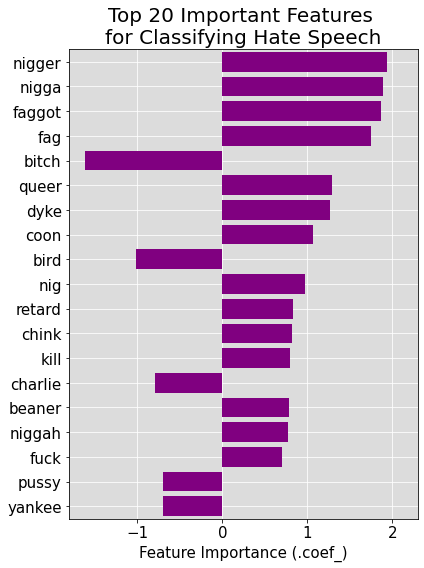

In [165]:
plot_feature_importance_HATE(model, n_features=20, save=True, fname='feature_imp_hate')